In [1]:
import numpy as np
import pandas as pd
import random
import torch
import os
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy

In [2]:
# Making model repeatable
random.seed(70)
np.random.seed(70)
torch.manual_seed(70)
torch.cuda.manual_seed(70)
torch.backends.cudnn.deterministic = True

In [44]:
# Loading data
data_root = '../Solution_for_test/'
print(os.listdir(data_root))

['.ipynb_checkpoints', 'best_model.pth', 'data', 'Model.ipynb']


In [4]:
# Spliting data on train, validation and test sets (every 10th image goes to validation or test sets)

import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

class_names = ['0', '1', '2', '3', '4', '5']

for dir_name in [train_dir, val_dir, test_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'data', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 10 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        elif i // 10 % 2 !=0:
            dest_dir = os.path.join(val_dir, class_name)
        else: 
            dest_dir = os.path.join(test_dir, class_name)

        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 425.49it/s]


In [5]:
# Making transforms and using data loaders

from torchvision import datasets,transforms, models

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

chosen_transforms = {'train': transforms.Compose([ 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std)]), 
        'val': transforms.Compose([ 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std)]), 
        'test': transforms.Compose([ 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std)])}

all_datsets = ['train', 'val', 'test']   

# Preparing datasets and dataloader

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_root, x),
                  chosen_transforms[x])
                  for x in all_datsets}
BATCH_SIZE = 27

dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=BATCH_SIZE,
              shuffle=True, num_workers=BATCH_SIZE)
              for x in all_datsets}

dataset_sizes = {x: len(chosen_datasets[x]) for x in all_datsets}
class_names = chosen_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Visualizing some images

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean_ = np.array([mean])
    std_ = np.array([std])
    inp = std_ * inp + mean_
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

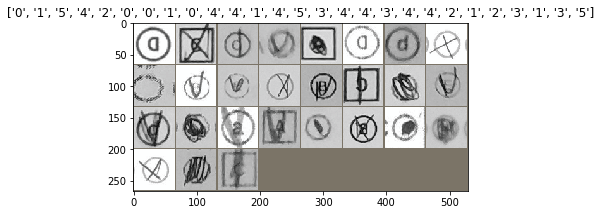

In [7]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Setting up the model (load in pretrained and reset final fully connected)

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 6)

# Freazing all layers, exept layer3 and layer4

for name, child in model.named_children():
    if name in ['layer3', 'layer4']:
        print(name + ' has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

# model.bn = torch.nn.BatchNorm1d(model.fc.in_features)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Choosing loss function
loss = torch.nn.CrossEntropyLoss()

# Choosing optimizer and apply it only to unfreazned layers
# optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=0.00001)
optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, model.parameters()), lr=1.0e-3, weight_decay=0.00001)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.75, weight_decay=0.00001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=1.0e-3,weight_decay=0.00001)

# Decay LR by a factor of 0.1 every 3 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

layer3 has been unfrozen.
layer4 has been unfrozen.


In [9]:
# Function to train model, returning best model (based on accurency at validation set)

def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_model = copy.deepcopy(model)
    best_score = 0
    best_loss = None
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            dataloader = dataloaders[phase]
            if phase == 'train':
                model.train()
                scheduler.step() # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            
            if (phase=='train'):
                train_accuracy_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            elif (phase=='val'):
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                if epoch_acc > best_score or (epoch_acc==best_score and best_loss > epoch_loss):
                    best_score = epoch_acc
                    best_loss = epoch_loss
                    best_model = copy.deepcopy(model)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    
    return best_model

In [40]:
# Training model and collecting statistic

train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []
best_model = train_model(model, loss, optimizer, scheduler, num_epochs=5)


Epoch 0/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:13<00:00,  4.95it/s]


train Loss: 0.0178 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:28<00:00,  2.36s/it]


val Loss: 0.0188 Acc: 0.9938
Epoch 1/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:07<00:00,  5.00it/s]


train Loss: 0.0199 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:29<00:00,  2.43s/it]


val Loss: 0.0188 Acc: 0.9938
Epoch 2/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  5.00it/s]


train Loss: 0.0163 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.23s/it]


val Loss: 0.0187 Acc: 0.9938
Epoch 3/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:10<00:00,  4.94it/s]


train Loss: 0.0172 Acc: 0.9954


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:29<00:00,  2.44s/it]


val Loss: 0.0183 Acc: 0.9938
Epoch 4/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:07<00:00,  5.07it/s]


train Loss: 0.0165 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:25<00:00,  2.09s/it]


val Loss: 0.0202 Acc: 0.9938
Epoch 5/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  4.92it/s]


train Loss: 0.0198 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.24s/it]


val Loss: 0.0213 Acc: 0.9938
Epoch 6/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  4.92it/s]


train Loss: 0.0196 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.65s/it]


val Loss: 0.0182 Acc: 0.9938
Epoch 7/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:12<00:00,  4.75it/s]


train Loss: 0.0165 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.22s/it]


val Loss: 0.0237 Acc: 0.9938
Epoch 8/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  4.96it/s]


train Loss: 0.0163 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:25<00:00,  2.12s/it]


val Loss: 0.0169 Acc: 0.9938
Epoch 9/9:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:09<00:00,  4.96it/s]


train Loss: 0.0186 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:29<00:00,  2.47s/it]


val Loss: 0.0218 Acc: 0.9938


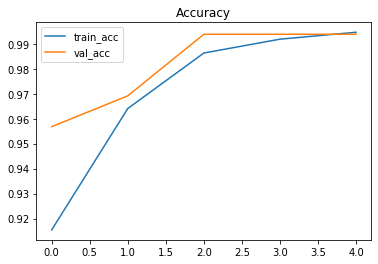

In [11]:
# Statistic of accuracy

plt.plot(train_accuracy_history, label='train_acc')
plt.plot(val_accuracy_history, label='val_acc')
plt.legend()
plt.title('Accuracy');

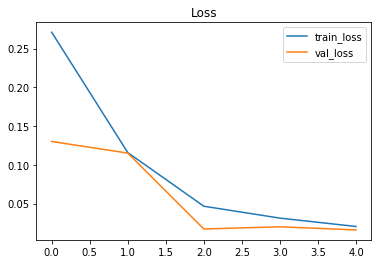

In [12]:
# Statistic of loss

plt.plot(train_loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.legend()
plt.title('Loss');

In [38]:
#Function to visualize result of prediction model on dataset

def visualize_model(model, name_of_dataset, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[name_of_dataset]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

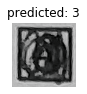

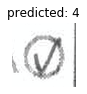

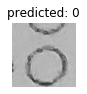

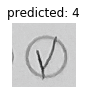

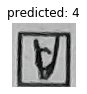

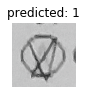

In [39]:
visualize_model(best_model, 'test')
plt.show()
# inputs, classes = next(iter(dataloaders['train']))
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_names[x] for x in classes])

In [28]:
# Function to calculate accurancy for model on dataset

def acc_for_dataset(model, name_of_dataset):
    running_loss = 0.
    running_acc = 0.
    dataloader = dataloaders[name_of_dataset]
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # forward and backward
        with torch.set_grad_enabled(False):
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)

        # statistics
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()

    loss_ = running_loss / len(dataloader)
    acc_ = running_acc / len(dataloader)
    print('For', name,'acc is:', np.round(acc_.item(),4))
    print('For', name,'loss is:', np.round(loss_,4))
#     return (loss_, acc_)     

In [29]:
for name in all_datsets:
    acc_for_dataset(best_model, name)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.38it/s]


For train acc is: 0.9987
For train loss is: 0.0067


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.03s/it]


For val acc is: 0.9938
For val loss is: 0.0157


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.05s/it]


For test acc is: 1.0
For test loss is: 0.0063


In [43]:
# Saving best model

torch.save(best_model.state_dict(), os.path.join(data_root, 'best_model.pth'))

In [41]:
# Remove split datasets

for dir_name in all_datsets:
    shutil.rmtree(os.path.join(data_root, dir_name))